# Importing usefull libraries and activating the GPU

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f'{len(physical_devices)} devices found')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

1 devices found


# Data
### We use the movielens dataset
### We load the rating data which contains movieID, userID and respective rating
### We also load movies data to know which movie is represented by which movieID
### Finally we merge the 2 dataframes

In [3]:
%%time
df = pd.read_csv('ratings.csv')
df.head()

Wall time: 5.66 s


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [4]:
movie_df = pd.read_csv('movies.csv')
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df = df.merge(movie_df, on = 'movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,851527569,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,849082742,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,835562174,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,846509384,Jumanji (1995),Adventure|Children|Fantasy


In [6]:
print('data types of dataframe is as follows \n\n',df.dtypes)

data types of dataframe is as follows 

 userId         int64
movieId        int64
rating       float64
timestamp      int64
title         object
genres        object
dtype: object


# Preprocessing
### We want to find embedding for movieID and userID, so we convert them into categorical and then reconvert them into codes using pandas functions. This way we make sure that both the columns start from 0 .
### After preprocessing we add new columns User_ID and Movie_ID to save the new representation.

In [7]:
df['userId'] = pd.Categorical(df['userId'])
df['movieId'] = pd.Categorical(df['movieId'])

df['User_ID'] = df['userId'].cat.codes
df['Movie_ID'] = df['movieId'].cat.codes

In [8]:
df.head()

,userId,movieId,rating,timestamp,title,genres,User_ID,Movie_ID
0,1,2,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy,0,1
1,5,2,3.0,851527569,Jumanji (1995),Adventure|Children|Fantasy,4,1
2,13,2,3.0,849082742,Jumanji (1995),Adventure|Children|Fantasy,12,1
3,29,2,3.0,835562174,Jumanji (1995),Adventure|Children|Fantasy,28,1
4,34,2,3.0,846509384,Jumanji (1995),Adventure|Children|Fantasy,33,1


# Data
### We only need the ID's and ratings for our regression task i.e. collaborative filtering

In [9]:
user_id = df['User_ID'].values
movie_id = df['Movie_ID'].values
rating = df['rating'].values

# Lengths
### After preprocessing our ID's start from 0.
### U stores total number of unique user IDs and M stores total number of unique movie IDs
### We decide 25 dimensions as our embedding vector shape

In [10]:
U = len(set(user_id))
M = len(set(movie_id))

dim_embedd = 15
print(f'number of users are {U}')
print(f'number of movies are {M}')

number of users are 138493
number of movies are 26744


# Splitting
### Instead of using train_test_split, we shuffle the data and use 70 % for training and rest for testing

In [11]:
user_id, movie_id, rating = shuffle(user_id, movie_id, rating)

train_length = int(0.7*len(user_id))

train_user = user_id[:train_length]
train_movie = movie_id[:train_length]
train_rating = rating[:train_length]


test_user = user_id[train_length:]
test_movie = movie_id[train_length:]
test_rating = rating[train_length:]


# Model
### This is a parallel model where the user ID and movie ID are input parallel
### The IDs are Embedded separately i.e. parallely
### We then join the flattened embeddings together for regression
### We have 2 fully connected layers each with 512 neurons for regression.
### We compile using mse as loss and SGD with learning rate = 0.08 and momentum = 0.9


In [12]:
# Input the user and movie id's
user_input = Input(shape = (1,))
movie_input = Input(shape = (1,))

# embedding for user and movie id's
user_embedding = Embedding(U, dim_embedd)(user_input)
movie_embedding = Embedding(M, dim_embedd)(movie_input)

#Flattening the Embeddings
user_embedding = Flatten()(user_embedding)
movie_embedding = Flatten()(movie_embedding)

# Concatenate the two embedding for regression of rating
o = Concatenate()([user_embedding, movie_embedding])

# Fully connected layers
o = Dense(512, activation = 'relu')(o)
o = Dropout(0.2)(o)
o = Dense(512, activation = 'relu')(o)
o = Dropout(0.2)(o)
o = Dense(1)(o)

In [13]:
model = Model(inputs = [user_input, movie_input], outputs = o)
model.compile(optimizer = SGD(lr = 0.08, momentum = 0.9), loss = 'mse')

C:\Users\mishr\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        2077395     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        401160      input_2[0][0]                    
______________________________________________________________________________________________

# Fitting the model
### We train the model for 20 epochs

In [15]:
r = model.fit([train_user, train_movie], train_rating,
              validation_data = ([test_user, test_movie], test_rating),
             batch_size = 2048,
             epochs = 28)

Epoch 1/28
6837/6837 [==============================] - 47s 6ms/step - loss: 0.8457 - val_loss: 0.7613
Epoch 2/28
6837/6837 [==============================] - 43s 6ms/step - loss: 0.7354 - val_loss: 0.7336
Epoch 3/28
6837/6837 [==============================] - 42s 6ms/step - loss: 0.7099 - val_loss: 0.7218
Epoch 4/28
6837/6837 [==============================] - 43s 6ms/step - loss: 0.6950 - val_loss: 0.7103
Epoch 5/28
6837/6837 [==============================] - 42s 6ms/step - loss: 0.6857 - val_loss: 0.6994
Epoch 6/28
6837/6837 [==============================] - 43s 6ms/step - loss: 0.6777 - val_loss: 0.7139
Epoch 7/28
6837/6837 [==============================] - 45s 7ms/step - loss: 0.6697 - val_loss: 0.7026
Epoch 8/28
6837/6837 [==============================] - 45s 7ms/step - loss: 0.6624 - val_loss: 0.7091
Epoch 9/28
6837/6837 [==============================] - 44s 6ms/step - loss: 0.6566 - val_loss: 0.6820
Epoch 10/28
6837/6837 [==============================] - 46s 7ms/step - l

# History plotter
### The history plotter plots the training and validation loss at each epochs

In [16]:
def history_plotter(model, argument):
    sns.set()
    plt.plot(model.history[argument], label = argument)
    plt.plot(model.history['val_'+argument], label = 'validation '+argument)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel(argument)
    plt.title(argument)

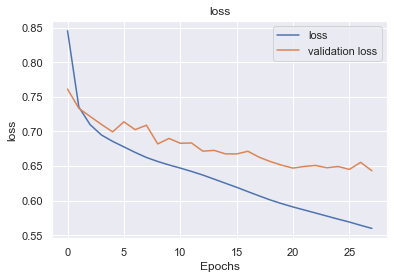

In [17]:
history_plotter(r, 'loss')